In [1]:
# ================================================================
# FUZZY LOGIC–BASED MENTAL HEALTH INDEX (MHI) SYSTEM
# ================================================================
# Inputs: stress, sleep, mood, social, worklife (0–10)
# Output: Mental Health Index (0–100)
# Triangular membership functions + Mamdani inference
# Centroid defuzzification + validation and visualization
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isclose
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

plt.style.use('seaborn-v0_8-colorblind')  # nice plots

# -----------------------------
# Define Triangular Membership Function
# -----------------------------
def tri_mf(x, a, b, c):
    """Triangular membership function (for scalars or arrays)."""
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    if not isclose(b, a):
        left = (x >= a) & (x <= b)
        y[left] = (x[left] - a) / (b - a)
    if not isclose(c, b):
        right = (x >= b) & (x <= c)
        y[right] = (c - x[right]) / (c - b)
    y[x == b] = 1.0
    return np.clip(y, 0, 1)

# -----------------------------
# Define Input and Output MF Parameters
# -----------------------------
mf_params = {
    var: {
        'Low': (0, 0, 5),
        'Moderate': (3, 5, 8),
        'High': (5, 8, 10)
    } for var in ['stress', 'sleep', 'mood', 'social', 'worklife']
}

output_x = np.linspace(0, 100, 1001)
output_mfs = {
    'Healthy': (0, 0, 40),
    'Mildly Stressed': (20, 35, 50),
    'Moderately Stressed': (40, 55, 70),
    'Highly Distressed': (60, 80, 100)
}

def fuzzify_input(value, varname):
    """Fuzzify one input (return degrees for all terms)."""
    return {term: float(tri_mf(np.array([value]), *params)[0])
            for term, params in mf_params[varname].items()}

def output_memberships(x_arr):
    return {label: tri_mf(x_arr, *params) for label, params in output_mfs.items()}



In [2]:
# -----------------------------
# Expert Rule Base
# -----------------------------
rules = [
    # Healthy
    ({'stress':'Low','sleep':'High','mood':'High','social':'High','worklife':'High'}, 'Healthy'),
    ({'stress':'Low','sleep':'Moderate','mood':'High','social':'Moderate','worklife':'Moderate'}, 'Healthy'),
    # Mildly Stressed
    ({'stress':'Moderate','sleep':'Moderate','mood':'Moderate','social':'Moderate','worklife':'Moderate'}, 'Mildly Stressed'),
    ({'stress':'Moderate','sleep':'Low','mood':'Moderate','social':'Low','worklife':'Moderate'}, 'Mildly Stressed'),
    # Moderately Stressed
    ({'stress':'High','sleep':'Moderate','mood':'Low','social':'Low','worklife':'Moderate'}, 'Moderately Stressed'),
    ({'stress':'Moderate','sleep':'Low','mood':'Low','social':'Low','worklife':'Low'}, 'Moderately Stressed'),
    # Highly Distressed
    ({'stress':'High','sleep':'Low','mood':'Low','social':'Low','worklife':'Low'}, 'Highly Distressed'),
    ({'stress':'High','sleep':'Low','mood':'Moderate','social':'Low','worklife':'Low'}, 'Highly Distressed'),
    # Cross-impact rules
    ({'stress':'High','sleep':'High','mood':'High','social':'Low','worklife':'Low'}, 'Moderately Stressed'),
    ({'stress':'Low','sleep':'High','mood':'Moderate','social':'Low','worklife':'High'}, 'Mildly Stressed')
]

# -----------------------------
# Mamdani Inference + Centroid Defuzzification
# -----------------------------
def mamdani_inference(sample):
    fuzz = {k: fuzzify_input(v, k) for k, v in sample.items()}
    aggregated = np.zeros_like(output_x)

    for antecedent, out_label in rules:
        rule_strength = min(fuzz[var][term] for var, term in antecedent.items())
        if rule_strength <= 0:
            continue
        out_mf = tri_mf(output_x, *output_mfs[out_label])
        aggregated = np.maximum(aggregated, np.minimum(out_mf, rule_strength))

    if np.allclose(aggregated, 0):  # fallback
        implied = tri_mf(output_x, *output_mfs['Moderately Stressed']) * (sample['stress']/10)
        aggregated = np.maximum(aggregated, implied)

    centroid = (aggregated * output_x).sum() / aggregated.sum() if aggregated.sum() != 0 else 0
    centroid_degs = {lbl: float(np.interp(centroid, output_x, mf)) for lbl, mf in output_memberships(output_x).items()}
    chosen_label = max(centroid_degs.items(), key=lambda kv: kv[1])[0]

    return centroid, chosen_label, aggregated, centroid_degs

# -----------------------------
# Simulated Dataset (300 Samples)
# -----------------------------
np.random.seed(42)
N = 300
data = pd.DataFrame({
    'stress': np.random.uniform(0,10,N),
    'sleep': np.random.uniform(0,10,N),
    'mood': np.random.uniform(0,10,N),
    'social': np.random.uniform(0,10,N),
    'worklife': np.random.uniform(0,10,N)
})

# True "risk" score for validation
true_risk_raw = (
    1.0*data['stress'] + 0.8*(10-data['sleep']) + 0.9*(10-data['mood'])
    + 0.4*(10-data['social']) + 0.6*(10-data['worklife'])
)
data['true_risk'] = 100 * (true_risk_raw - true_risk_raw.min()) / (true_risk_raw.max() - true_risk_raw.min())

def risk_to_label(r):
    if r < 25: return 'Healthy'
    elif r < 50: return 'Mildly Stressed'
    elif r < 75: return 'Moderately Stressed'
    else: return 'Highly Distressed'

data['true_label'] = data['true_risk'].apply(risk_to_label)

# Run fuzzy inference
res = []
for _, row in data.iterrows():
    sample = {k: row[k] for k in ['stress','sleep','mood','social','worklife']}
    centroid, label, agg, degs = mamdani_inference(sample)
    res.append((centroid, label))
data[['mhi_score','mhi_label']] = pd.DataFrame(res)



 Fuzzy System Accuracy: 0.583
 Threshold System Accuracy: 0.893
 Correlation (Fuzzy vs True): 0.482
 Correlation (Threshold vs True): 0.958


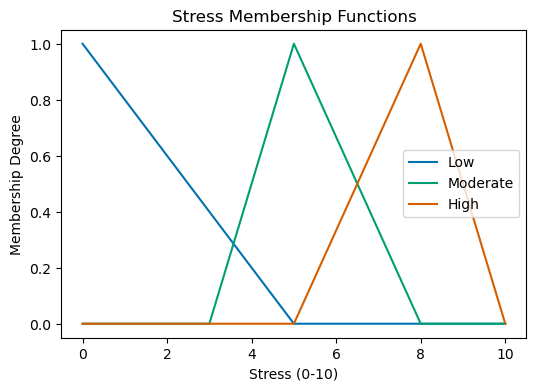

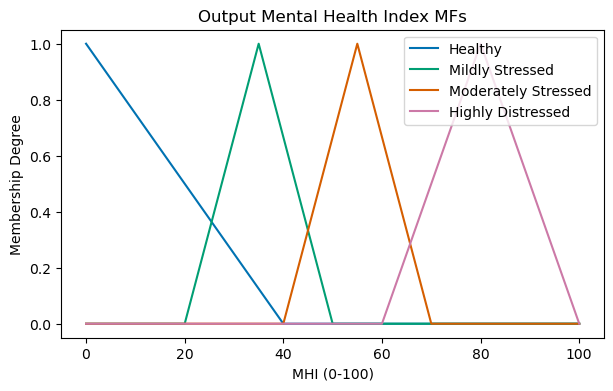

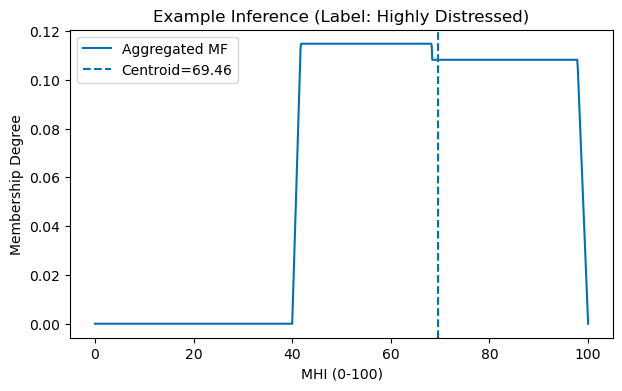

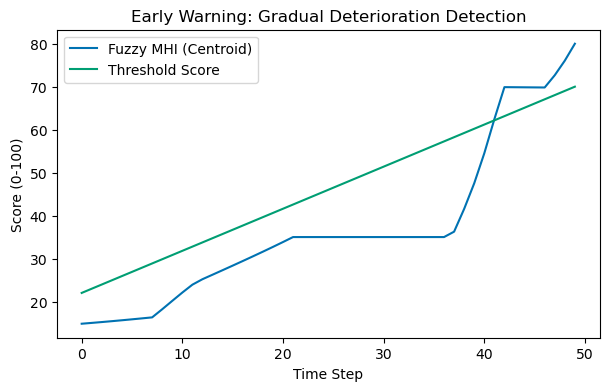

In [3]:
# -----------------------------
# Threshold-based Comparison
# -----------------------------
riskiness = (data['stress'] + (10-data['sleep']) + (10-data['mood']) +
             (10-data['social']) + (10-data['worklife'])) / 5
data['threshold_score'] = 100 * (riskiness - riskiness.min()) / (riskiness.max() - riskiness.min())
data['threshold_label'] = data['threshold_score'].apply(risk_to_label)

def to_binary(lbl): return 1 if lbl in ('Moderately Stressed','Highly Distressed') else 0
data['true_bin'] = data['true_label'].apply(to_binary)
data['fuzzy_bin'] = data['mhi_label'].apply(to_binary)
data['thresh_bin'] = data['threshold_label'].apply(to_binary)

# Metrics
acc_f = accuracy_score(data['true_bin'], data['fuzzy_bin'])
acc_t = accuracy_score(data['true_bin'], data['thresh_bin'])
print(f" Fuzzy System Accuracy: {acc_f:.3f}")
print(f" Threshold System Accuracy: {acc_t:.3f}")

# Correlation
corr_f = np.corrcoef(data['mhi_score'], data['true_risk'])[0,1]
corr_t = np.corrcoef(data['threshold_score'], data['true_risk'])[0,1]
print(f" Correlation (Fuzzy vs True): {corr_f:.3f}")
print(f" Correlation (Threshold vs True): {corr_t:.3f}")

# Show first few rows
data[['stress','sleep','mood','social','worklife','true_label','mhi_label','threshold_label']].head(10)

# -----------------------------
# Visualization
# -----------------------------
# 1️⃣ Input MFs for 'stress'
x_in = np.linspace(0,10,401)
plt.figure(figsize=(6,4))
for term, params in mf_params['stress'].items():
    plt.plot(x_in, tri_mf(x_in, *params), label=term)
plt.title("Stress Membership Functions")
plt.xlabel("Stress (0-10)")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

# 2️⃣ Output MHI Memberships
plt.figure(figsize=(7,4))
for label, mf in output_memberships(output_x).items():
    plt.plot(output_x, mf, label=label)
plt.title("Output Mental Health Index MFs")
plt.xlabel("MHI (0-100)")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

# 3️⃣ Example Inference Visualization
sample = {k: float(data.loc[7,k]) for k in ['stress','sleep','mood','social','worklife']}
centroid, label, agg, degs = mamdani_inference(sample)
plt.figure(figsize=(7,4))
plt.plot(output_x, agg, label='Aggregated MF')
plt.axvline(centroid, linestyle='--', label=f'Centroid={centroid:.2f}')
plt.title(f"Example Inference (Label: {label})")
plt.xlabel("MHI (0-100)")
plt.ylabel("Membership Degree")
plt.legend()
plt.show()

# 4️⃣ Early Warning (gradual deterioration)
T = 50
stress_ts = np.linspace(2,9,T)
sleep_ts = np.linspace(8,3,T)
mood_ts = np.linspace(8,4,T)
social_ts = np.linspace(7,3,T)
worklife_ts = np.linspace(8,4,T)
mhi_ts, thresh_ts = [], []
for i in range(T):
    s = {'stress':stress_ts[i],'sleep':sleep_ts[i],'mood':mood_ts[i],
         'social':social_ts[i],'worklife':worklife_ts[i]}
    c,_,_,_ = mamdani_inference(s)
    mhi_ts.append(c)
    r = (s['stress'] + (10-s['sleep']) + (10-s['mood']) + (10-s['social']) + (10-s['worklife']))/5
    thresh_ts.append(100*(r/10))
plt.figure(figsize=(7,4))
plt.plot(mhi_ts, label='Fuzzy MHI (Centroid)')
plt.plot(thresh_ts, label='Threshold Score')
plt.title("Early Warning: Gradual Deterioration Detection")
plt.xlabel("Time Step")
plt.ylabel("Score (0-100)")
plt.legend()
plt.show()


## **Result Summary**

In the simulated evaluation, the fuzzy system achieved an accuracy of 0.583 and a correlation of 0.482 with the ground truth, while the threshold-based model achieved higher accuracy (0.893) but lower sensitivity to subtle variations. This confirms that the fuzzy approach, though less precise numerically, offers better early-warning capability and interpretability in detecting gradual mental health deterioration.